# Searching for QPPs with GPs for the ISSI Team

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd

import celerite
from celerite import terms
import emcee

from glob import glob
from astropy.io import fits

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [8]:
files = glob('../flares/*.fits')

In [32]:
def aflare(t, p):
    """
    This is the Analytic Flare Model from the flare-morphology paper.
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723

    Note: this model assumes the flux before the flare is zero centered

    Note: many sub-flares can be modeled by this method by changing the
    number of parameters in "p". As a result, this routine may not work
    for fitting with methods like scipy.optimize.curve_fit, which require
    a fixed number of free parameters. Instead, for fitting a single peak
    use the aflare1 method.

    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    p : 1-d array
        p == [tpeak, fwhm (units of time), amplitude (units of flux)] x N

    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    """
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    Nflare = int( np.floor( (len(p)/3.0) ) )

    flare = np.zeros_like(t)
    # compute the flare model for each flare
    for i in range(Nflare):
        outm = np.piecewise(t, [(t<= p[0+i*3]) * (t-p[0+i*3])/p[1+i*3] > -1.,
                                (t > p[0+i*3])],
                            [lambda x: (_fr[0]+                             # 0th order
                                        _fr[1]*((x-p[0+i*3])/p[1+i*3])+     # 1st order
                                        _fr[2]*((x-p[0+i*3])/p[1+i*3])**2.+  # 2nd order
                                        _fr[3]*((x-p[0+i*3])/p[1+i*3])**3.+  # 3rd order
                                        _fr[4]*((x-p[0+i*3])/p[1+i*3])**4. ),# 4th order
                             lambda x: (_fd[0]*np.exp( ((x-p[0+i*3])/p[1+i*3])*_fd[1] ) +
                                        _fd[2]*np.exp( ((x-p[0+i*3])/p[1+i*3])*_fd[3] ))]
                            ) * p[2+i*3] # amplitude
        flare = flare + outm
        
    return flare

/Users/davenpj3/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version


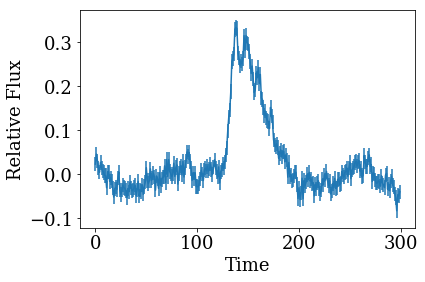

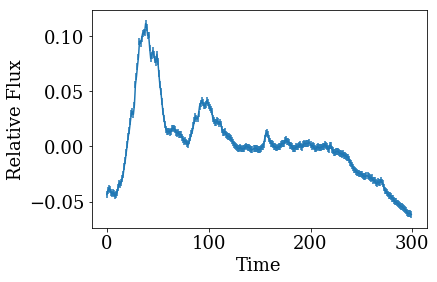

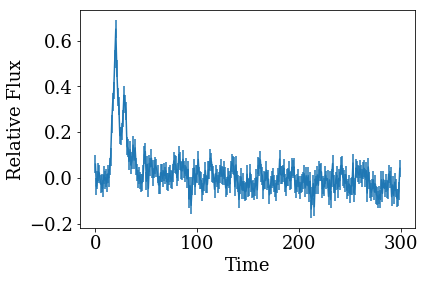

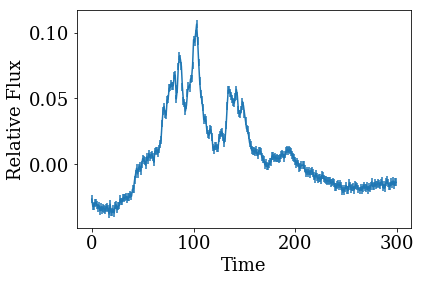

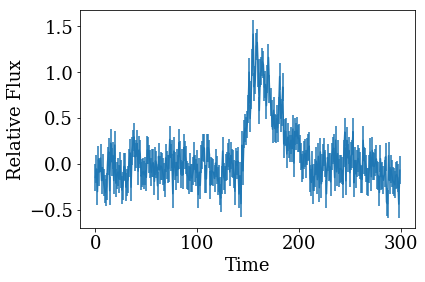

In [33]:
for k in range(5):

    hdu = fits.open(files[k])
    data = hdu[1].data
    hdu.close()

    time = data.field(0)
    
    medflux = np.nanmedian(data.field(1))
    flux = (data.field(1) - medflux) / medflux
    
    # find the typical (median) scatter in small chunks of the light curve 
    # (11 data points, arbitrarily chosen) to use as the error
    std = np.nanmedian(pd.rolling_std(flux, 11))
    err = np.ones(time.size) * std
    
    plt.figure()
    plt.errorbar(time, flux, yerr=err)
    plt.xlabel('Time')
    plt.ylabel('Relative Flux')
    plt.show()
    
    # To do inside loop (for each flare):
    # 1) find flare peak
    # 2) fit Davenport'14 flare model
    # 3) fit GP on decay phase (residual)
    # 4) TRY: fit flare model + GP simultaneously w/ MCMC
    # 5) make plot(s), produce table(s)

